In [4]:
using CairoMakie, DiffusionSplineFE, OrdinaryDiffEq, Interpolations

In [5]:
function load_interpolated_parameters() 
     # Input Parameters from Sellers Paper, estimated from observational data for one hemisphere
     colat_1 = (-90.:10.:90.)./90. # used for C,Q,T_0
     colat_2 = (-85.:10.:85.)./90. # used for b,z,k_1,k_2
     
     # An intial condition given in the paper
     T_0 = [247.3625, 252.0740, 262.5715, 271.2980, 278.9325, 285.7530, 291.4090, 296.0815, 298.7815, 299.3510];
     
     # Combined air-land-sea effective heat capacity [cal/cm^2/K] / on grid
     C = [500, 1000, 1500, 4725, 5625, 5812, 5813, 5625, 6000, 5625] 
 
     # High-frequency solar irradiance [cal/cm^2/sec]
     Q = [0.426, 0.440, 0.484, 0.579, 0.696, 0.804, 0.894, 0.961, 1.003, 1.017]*1e-2;
 
     # first value in the Ghil paper may be a typo, correction suggested by Tomas Bodai 
     b = [2.912, 2.96, 2.934, 2.914, 2.915, 2.868, 2.821, 2.804, 2.805]
 
     z = [1204.5, 820.0, 295.0, 150.5, 193.5, 301.0, 261.0, 133.5, 156.0] #[m]
 
     # Eddy diffusivity coefficients; k1*T'x: sensible heat flux,
     # k2*g(T)*T'x: latent heat flux
     k_1 = [0.47113, 0.61988, 1.19933, 1.50214, 1.51063, 1.69562, 2.02342, 3.20611, 4.80401]*1e-5; # [cal/K/cm^2/sec]
 
     # first value different from zero to prevent negative values at the pole during extrapolation
     k_2 = [0.3, 0.9314, 1.9772, 3.4348, 4.8316, 3.7359, 0.6903, -2.5401, -10.5975]*1e-2; # [cal/dyn/sec]
     
     # southern hemisphere gets the same constants 
     T_0 = [T_0; reverse(T_0[1:end-1])]
     C = [C; reverse(C[1:end-1])]
     Q = [Q; reverse(Q[1:end-1])]
     b = [b; reverse(b)]
     z = [z; reverse(z)]
     k_1 = [k_1; reverse(k_1)]
     k_2 = [k_2; reverse(k_2)]
     
     #flat boundary conditions correspond due to the Neumann BC
     T_0 = CubicSplineInterpolation(colat_1, T_0, bc=Interpolations.Flat(OnGrid()))
     C = CubicSplineInterpolation(colat_1, C, bc=Interpolations.Flat(OnGrid()))
     Q = CubicSplineInterpolation(colat_1, Q, bc=Interpolations.Flat(OnGrid()))
     b = CubicSplineInterpolation(colat_2, b, bc=Interpolations.Flat(OnCell()))
     z = CubicSplineInterpolation(colat_2, z, bc=Interpolations.Flat(OnCell()))
     k_1 = CubicSplineInterpolation(colat_2, k_1, bc=Interpolations.Flat(OnCell()))
     k_2 = CubicSplineInterpolation(colat_2, k_2, bc=Interpolations.Flat(OnCell()))

     return T_0, C, Q, b, z, k_1, k_2
end

Base.@kwdef struct ContinousGhilSellersParameters{T}
    T_0::Interpolations.Extrapolation{T}
    μ::T
    C::Interpolations.Extrapolation{T}
    Q::Interpolations.Extrapolation{T}
    b::Interpolations.Extrapolation{T}
    z::Interpolations.Extrapolation{T}
    k_1::Interpolations.Extrapolation{T}
    k_2::Interpolations.Extrapolation{T}
    c_1::T = 0.009
    c_2::T = 0.0065
    c_3::T = 1.9e-15
    c_4::T = 6.105*0.75*exp(19.6)
    c_5::T = 5350. 
    σ::T = 1.356e-12 # Stefan Boltzmann constant (in CGS system)
    m::T = 0.5 # atmospheric attenuation coefficient (0.5 for present conditions)
    T_m::T = 283.16;
    α_max::T = 0.65;
end 

function ContinousGhilSellersParameters(μ=1., m=0.5)
    T_0, C, Q, b, z, k_1, k_2 = load_interpolated_parameters()  
    ContinousGhilSellersParameters(T_0=T_0, μ=μ, C=C, Q=Q, b=b, z=z, k_1=k_1, k_2=k_2, m=m)
end 

p = ContinousGhilSellersParameters()

α(x, T, p::ContinousGhilSellersParameters) = cutoff_function.(p.b(x) - p.c_1 .* (p.T_m .+ min.(0, T - p.c_2 .* p.z(x) .- p.T_m)), p.α_max)

function cutoff_function(x, max_val) 
    if x <= 0.25
        return 0.25
    elseif x >= max_val
        return max_val
    else 
        return x
    end 
end

"""
    k(x,T,p::ContinousGhilSellersParameters)

Heat flux, first term sensible heat flux, second term latent heat flux
"""
k(x, T, p::ContinousGhilSellersParameters) = p.k_1(x) + p.k_2(x) .* g(T,p)

"""
    g(T,p::ContinousGhilSellersParameters)

Latent heat flux contribution
"""
g(T,p::ContinousGhilSellersParameters) = p.c_4 .* exp.(-p.c_5 ./ T) ./ (T.^2)

g

In [3]:
D(x, T) = (2/π)^2 * cos(π*x/2)*k(x, T, p)
S(x, T) = cos(π*x/2) * (p.μ*p.Q(x)*(1. - α(x, T, p)) - p.σ*T^4*(1.0 - p.m*tanh(p.c_3*T^6)))
C(x) = p.C(x)*cos(π*x/2)

C (generic function with 1 method)

In [61]:
n = 11
knots = collect(range(-1, 1, length=n))
SC = SplineComplex(knots, 4)

tspan = (0, 3e9)
f(x) = 273.
u0 = initial_coefficients(SC, f)
prob = NonlinearDiffusionProblem(SC, C, D, S, u0, tspan)

sol = solve(prob, Tsit5());

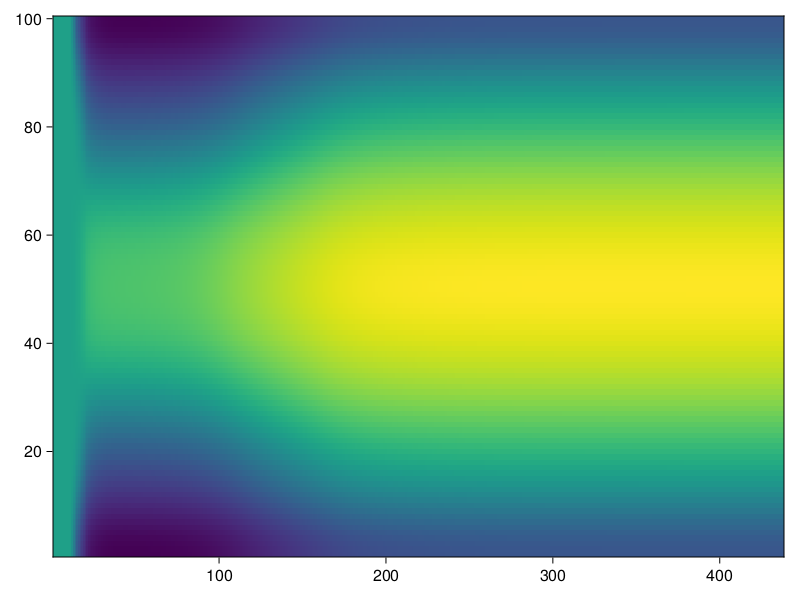

In [62]:
heatmap(SC, sol)

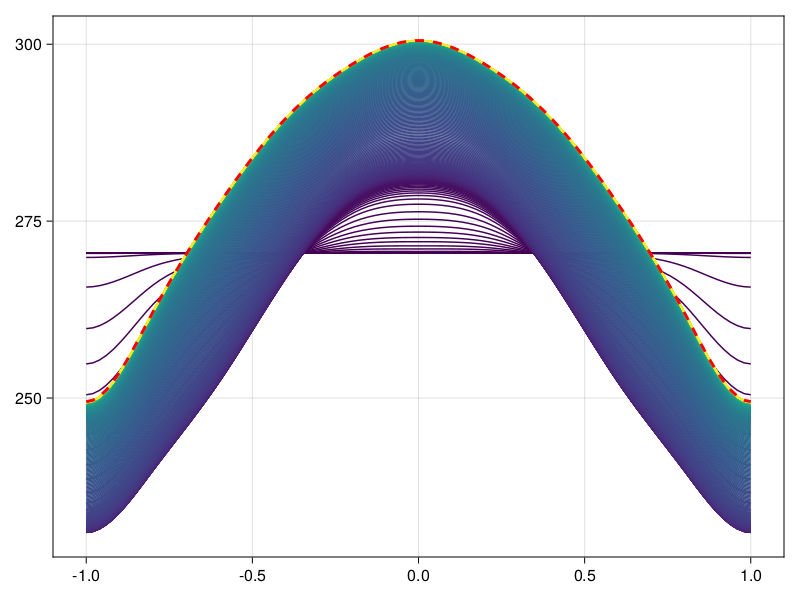

In [64]:
fig, ax, ln = diffusionplot(SC, sol, 100)
lines!(ax, SC, sol[end], color=:red, linestyle=:dash, linewidth=3)
fig